# Trajectory Inference for Three Slices of the Mouse Thymus Dataset

## Loading Packages

In [47]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [48]:
def load_data(replicate):
    """
    Load data from files for each replicate and store them in a dictionary.
    
    Parameters:
    - replicate: list of strings, the replicate identifiers.
    
    Returns:
    - adata_analysis: dictionary, where keys are replicate identifiers and values are AnnData objects.
    """
    adata_analysis = {}
    for rep in replicate:
        file_path = f'../../../Mouse_Thymus_Replicate{rep}.h5ad'
        adata_analysis[f'replicate_{rep}'] = sc.read_h5ad(file_path)
    return adata_analysis

replicate = ['1', '2', '3']
adata_analysis = load_data(replicate)

## Calculating UMAP

In [66]:
def calculate_umap(adata, methods):
    """
    Calculate UMAP for each method and store the results in the AnnData object.
    
    Parameters:
    - adata: AnnData object, the data to process.
    - methods: list of strings, the methods to calculate UMAP for.
    """
    for method in methods:
        if method in adata.obsm:
            sc.pp.neighbors(adata, use_rep=method)
            sc.tl.umap(adata, min_dist=0.5, spread=0.5)
            adata.obsm[f'{method}_UMAP'] = adata.obsm['X_umap']
            del adata.obsm['X_umap']
        else:
            print(f"Method '{method}' not found in obsm.")

methods_analysis = ['SpaKnit', 'SpatialGlue', 'Seurat', 'STAGATE']

## Calculating Centroids

In [78]:
def calculate_centroids(adata, methods):
    """
    Calculate centroids for each cluster of each method.
    
    Parameters:
    - adata: AnnData object, the data to process.
    - methods: list of strings, the methods to calculate centroids for.
    
    Returns:
    - centroids_dict: dictionary, where keys are method names and values are dictionaries of centroids.
    """
    centroids_dict = {}
    for method in methods:
        umap_key = f'{method}_UMAP'
        if umap_key in adata.obsm:
            unique_clusters = np.unique(adata.obs[method])
            centroids = {}
            for cluster in unique_clusters:
                umap_coords = adata[adata.obs[method] == cluster].obsm[umap_key]
                centroid = np.mean(umap_coords, axis=0)
                centroids[cluster] = centroid
            centroids_dict[method] = centroids
        else:
            print(f"UMAP for method '{method}' not found in obsm.")
            centroids_dict[method] = None
    return centroids_dict

## PAGA Analysis

In [79]:
def perform_paga(adata, methods):
    """
    Perform PAGA for each method and store the results in the AnnData object.
    
    Parameters:
    - adata: AnnData object, the data to process.
    - methods: list of tuples, where each tuple contains the cluster key and the embedding key.
    """
    for cluster_key, embed_key in methods:
        sc.pp.neighbors(
            adata, 
            use_rep=embed_key, 
            key_added=f'neighbors_{cluster_key}', 
            n_neighbors=50
        )
        sc.tl.paga(
            adata,
            groups=cluster_key,
            neighbors_key=f'neighbors_{cluster_key}'
        )
        adata.uns[f'paga_{cluster_key}'] = adata.uns['paga'].copy()

methods = [
    ('SpaKnit', 'SpaKnit'),
    ('SpatialGlue', 'SpatialGlue'),
    ('Seurat', 'Seurat'),
    ('STAGATE', 'STAGATE'),
]

## Ploting Function

In [ ]:
def plot_umap_with_centroids(adata, methods, replicate, paga_thresholds, colors_by_replicate_and_method):
    """
    Plot UMAP with centroids and PAGA connections for each method in the given replicate.

    Parameters:
    adata (AnnData): The AnnData object containing the data.
    methods (list): A list of tuples, where each tuple contains the cluster key and embed key for a method.
    replicate (str): The current replicate being processed.
    paga_thresholds (dict): A dictionary where keys are method names and values are the corresponding PAGA thresholds.
    colors_by_replicate_and_method (dict): A dictionary where keys are replicate numbers, and values are dictionaries with method names as keys and color lists as values.
    """
    for cluster_key, embed_key in methods:
        umap_key = f'{embed_key}_UMAP'
        if umap_key not in adata.obsm or cluster_key not in adata.obs:
            print(f"Skipping {cluster_key} - data not found")
            continue
        
        # Get the color list corresponding to the current replicate and method
        colors = colors_by_replicate_and_method[replicate][cluster_key]
        
        unique_clusters = np.unique(adata.obs[cluster_key])
        centroids = {
            cluster: np.mean(adata[adata.obs[cluster_key] == cluster].obsm[umap_key], axis=0)
            for cluster in unique_clusters
        }
        print(f"Plot for {cluster_key} in replicate {replicate}:")
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.scatter(
            adata.obsm[umap_key][:, 0],
            adata.obsm[umap_key][:, 1],
            c=[colors[int(x) % len(colors)] for x in adata.obs[cluster_key]],
            s=100,
            alpha=0.7
        )
        
        # Plot centroids
        for cluster, centroid in centroids.items():
            ax.scatter(centroid[0], centroid[1], marker='o', color='black', s=300)
        
        # Plot PAGA connections
        paga_key = f'paga_{cluster_key}'
        if paga_key in adata.uns:
            connectivities = adata.uns[paga_key]['connectivities'].toarray()
            cluster_indices = {cluster: i for i, cluster in enumerate(unique_clusters)}
            threshold = paga_thresholds.get(cluster_key, 0.1)
            for i in range(len(unique_clusters)):
                for j in range(i + 1, len(unique_clusters)):
                    if connectivities[i, j] > threshold:
                        start = centroids[unique_clusters[i]]
                        end = centroids[unique_clusters[j]]
                        linewidth = 2 + 8 * connectivities[i, j]
                        ax.plot([start[0], end[0]], [start[1], end[1]], 
                               color='black', linewidth=linewidth, alpha=1)
        
        # Remove axis labels, ticks, and grid
        ax.set_title(f'')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        # Save and show the plot
        plt.tight_layout()
        plt.savefig(f'{cluster_key}_rep_{replicate}.png', dpi=500)
        plt.savefig(f'{cluster_key}_rep_{replicate}.eps')
        plt.show()

## Running

Plot for SpaKnit in replicate 1:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


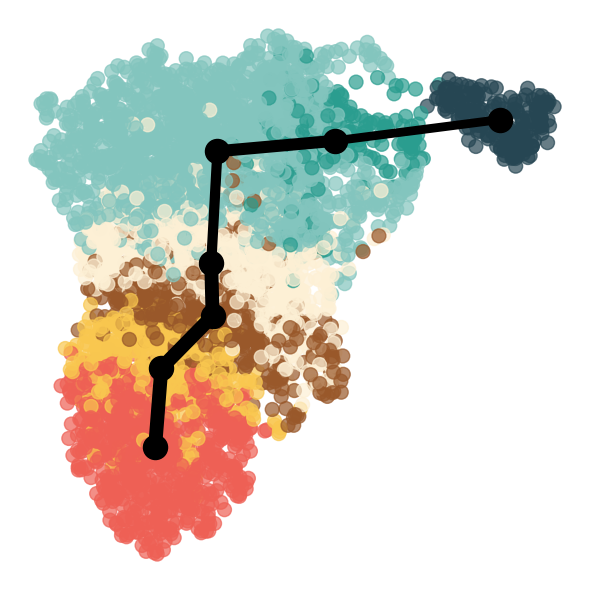

Plot for SpatialGlue in replicate 1:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


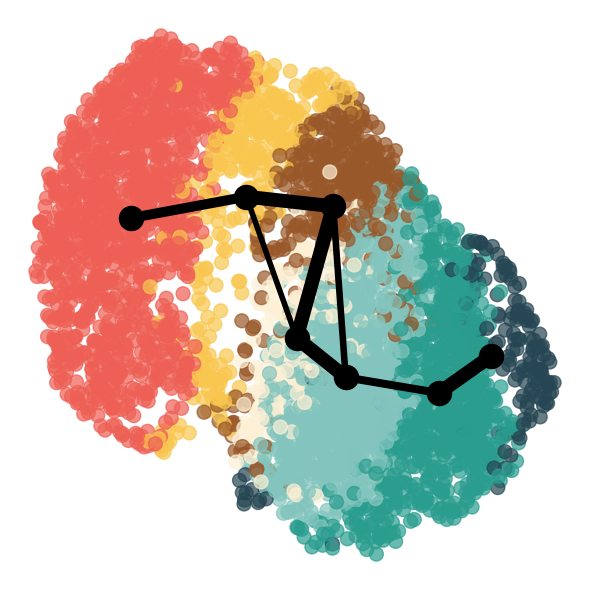

Plot for Seurat in replicate 1:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


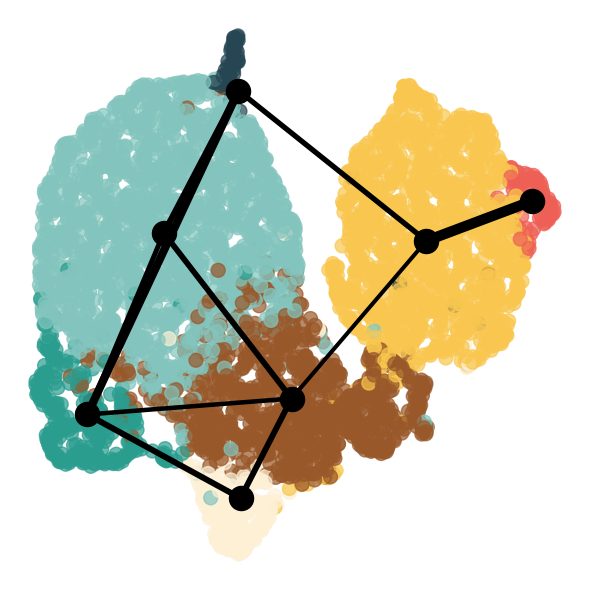

Plot for STAGATE in replicate 1:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


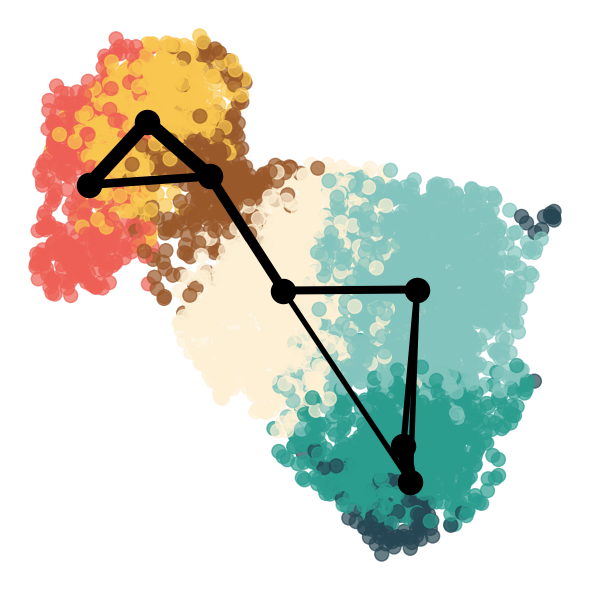

Plot for SpaKnit in replicate 2:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


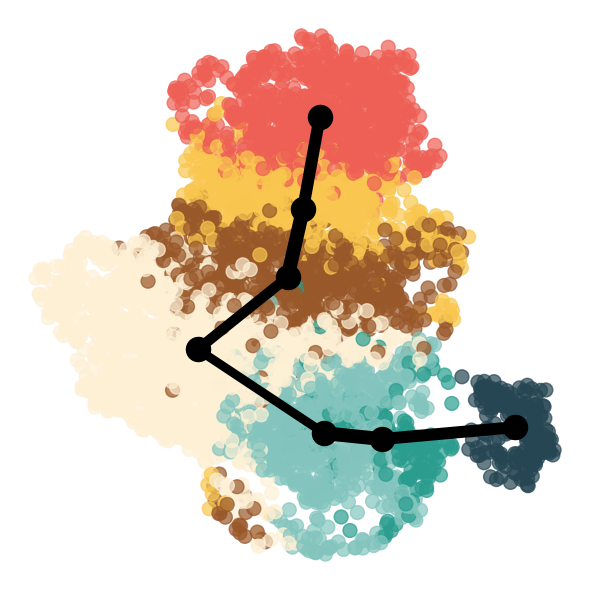

Plot for SpatialGlue in replicate 2:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


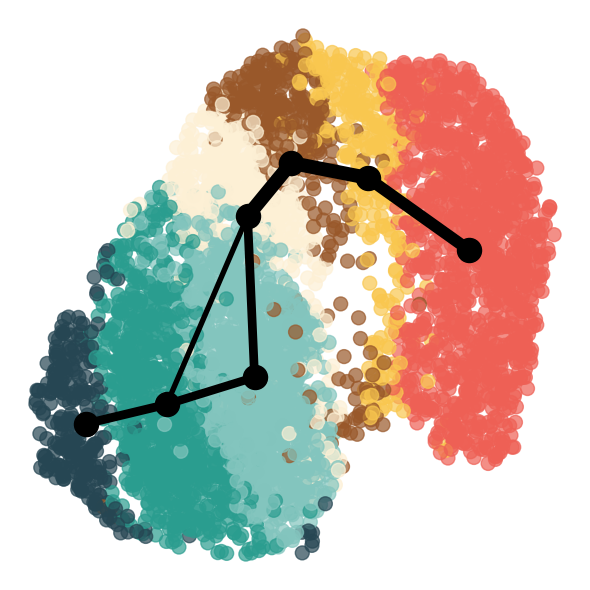

Plot for Seurat in replicate 2:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


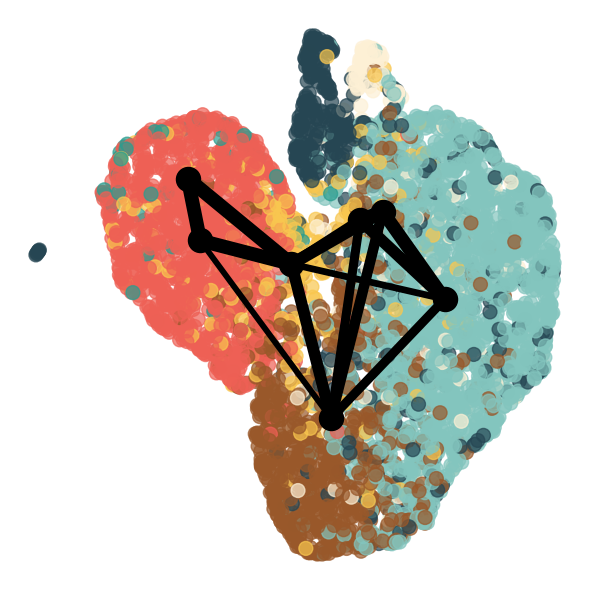

Plot for STAGATE in replicate 2:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


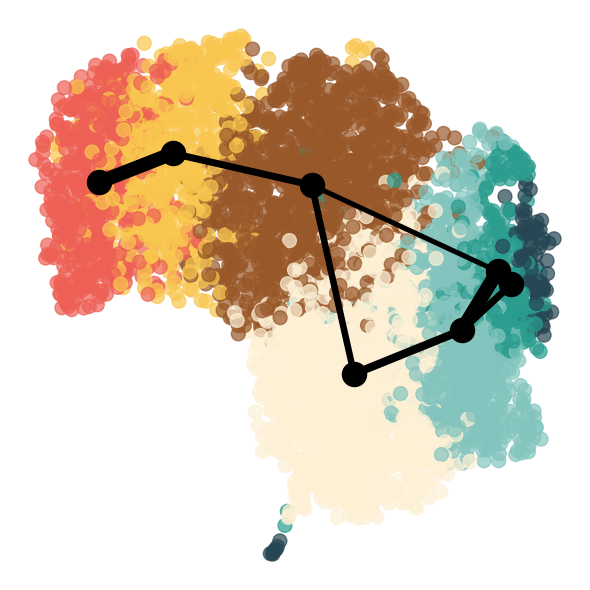

Plot for SpaKnit in replicate 3:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


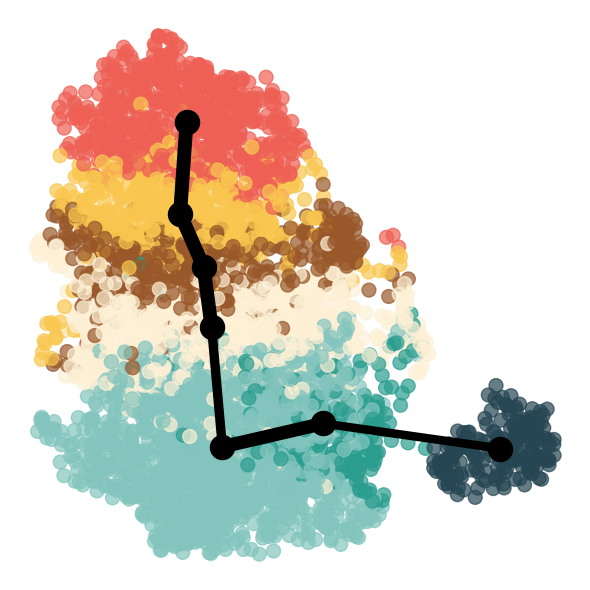

Plot for SpatialGlue in replicate 3:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


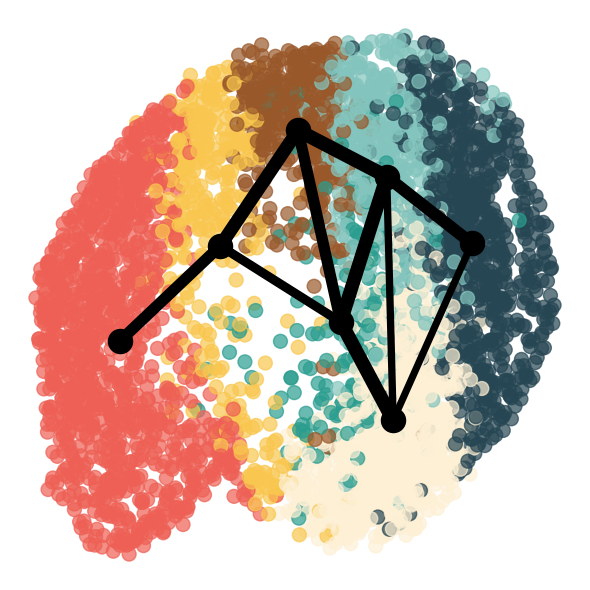

Plot for Seurat in replicate 3:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


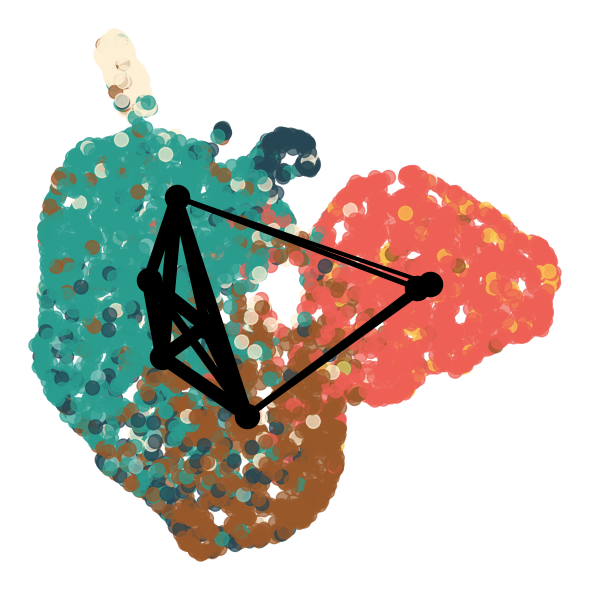

Plot for STAGATE in replicate 3:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


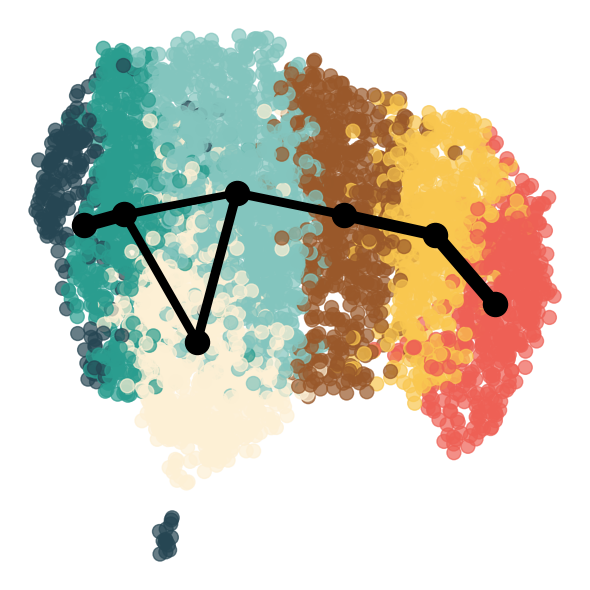

In [98]:
colors_by_replicate_and_method = {
    # Replicate 1
    '1': {
        'SpaKnit':     ['#fdf0d5', '#264653', '#83c5be', '#2a9d8f', '#f9c74f', '#99582a', '#ee6055'],
        'SpatialGlue': ['#f9c74f', '#83c5be', '#2a9d8f', '#fdf0d5', '#264653', '#ee6055', '#99582a'],
        'Seurat':      ['#83c5be', '#f9c74f', '#99582a', '#2a9d8f', '#fdf0d5', '#ee6055', '#264653'],
        'STAGATE':     ['#99582a', '#2a9d8f', '#83c5be', '#fdf0d5', '#264653', '#f9c74f', '#ee6055'],
    },
    # Replicate 2
    '2': {
        'SpaKnit':     ['#264653', '#ee6055', '#83c5be', '#99582a', '#fdf0d5', '#2a9d8f', '#f9c74f'],
        'SpatialGlue': ['#264653', '#fdf0d5', '#99582a', '#f9c74f', '#83c5be', '#ee6055', '#2a9d8f'],
        'Seurat':      ['#83c5be', '#ee6055', '#99582a', '#264653', '#f9c74f', '#fdf0d5', '#2a9d8f'],
        'STAGATE':     ['#fdf0d5', '#99582a', '#f9c74f', '#2a9d8f', '#83c5be', '#264653', '#ee6055'],
    },
    # Replicate 3
    '3': {
        'SpaKnit':     ['#264653', '#ee6055', '#99582a', '#f9c74f', '#83c5be', '#fdf0d5', '#2a9d8f'],
        'SpatialGlue': ['#f9c74f', '#99582a', '#fdf0d5', '#2a9d8f', '#83c5be', '#ee6055', '#264653'],
        'Seurat':      ['#2a9d8f', '#ee6055', '#99582a', '#264653', '#fdf0d5', '#f9c74f', '#83c5be'],
        'STAGATE':     ['#264653', '#2a9d8f', '#ee6055', '#fdf0d5', '#83c5be', '#99582a', '#f9c74f'],
    },
}

# Set PAGA thresholds for each method
paga_thresholds = {
    'SpaKnit': 0.45,
    'SpatialGlue': 0.2,
    'Seurat': 0.1,
    'STAGATE': 0.2
}

# Run
for rep in replicate:
    adata = adata_analysis[f'replicate_{rep}']
    calculate_umap(adata, methods_analysis)
    centroids_dict = calculate_centroids(adata, methods_analysis)
    perform_paga(adata, methods)
    plot_umap_with_centroids(
        adata, 
        methods, 
        rep, 
        paga_thresholds, 
        colors_by_replicate_and_method
    )